# Flight Price Prediction with Deep Learning

## 1. Setup & Data Loading

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Dropout, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, 
    r2_score, explained_variance_score
)

# Load and prepare base dataset
df_base = pd.read_csv('/kaggle/input/flight-price-prediction/Clean_Dataset.csv')
df_base = df_base.drop(columns=['Unnamed: 0', 'flight'])

## 2. Version 1 - Baseline Model

In [17]:
print("MODEL VERSION 1")

# Prepare V1 data
df_v1 = df_base.copy()
cat_cols_v1 = ['airline', 'source_city', 'departure_time', 'stops', 
               'arrival_time', 'destination_city', 'class']

for col in cat_cols_v1:
    df_v1[col] = df_v1[col].astype('category').cat.codes

X_v1 = df_v1.drop('price', axis=1)
y_v1 = df_v1['price']
X_train_v1, X_test_v1, y_train_v1, y_test_v1 = train_test_split(
    X_v1, y_v1, test_size=0.2, random_state=42
)

# Build V1 model
embedding_sizes_v1 = {col: (df_v1[col].nunique(), min(50, (df_v1[col].nunique() + 1) // 2)) 
                      for col in cat_cols_v1}

inputs_v1 = []
embeddings_v1 = []
for col in cat_cols_v1:
    inp = Input(shape=(1,))
    embedding = Embedding(input_dim=embedding_sizes_v1[col][0], 
                          output_dim=embedding_sizes_v1[col][1])(inp)
    embedding = Flatten()(embedding)
    inputs_v1.append(inp)
    embeddings_v1.append(embedding)

num_input_v1 = Input(shape=(X_train_v1.shape[1] - len(cat_cols_v1),))
inputs_v1.append(num_input_v1)
embeddings_v1.append(num_input_v1)

x_v1 = Concatenate()(embeddings_v1)
x_v1 = Dense(128, activation='relu')(x_v1)
x_v1 = Dropout(0.2)(x_v1)
x_v1 = Dense(64, activation='relu')(x_v1)
output_v1 = Dense(1)(x_v1)

model_v1 = Model(inputs=inputs_v1, outputs=output_v1)
model_v1.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train V1 model
history_v1 = model_v1.fit(
    [X_train_v1[col] for col in cat_cols_v1] + [X_train_v1.drop(cat_cols_v1, axis=1)],
    y_train_v1,
    validation_data=([X_test_v1[col] for col in cat_cols_v1] + [X_test_v1.drop(cat_cols_v1, axis=1)], y_test_v1),
    epochs=20,
    batch_size=1024,
    callbacks=[EarlyStopping(patience=3)]
)

# Save V1 model
model_v1.save('flight_price_model_v1.h5')

MODEL VERSION 1
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 894096640.0000 - mae: 19957.4746 - val_loss: 449987968.0000 - val_mae: 18243.6016
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 384860256.0000 - mae: 16652.4805 - val_loss: 133353384.0000 - val_mae: 9083.1074
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 95083680.0000 - mae: 7592.3740 - val_loss: 48607816.0000 - val_mae: 4975.2090
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 48881576.0000 - mae: 4907.2271 - val_loss: 40713312.0000 - val_mae: 4250.4658
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 41954524.0000 - mae: 4347.1392 - val_loss: 36730348.0000 - val_mae: 3939.8481
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 38213168.0000 - mae: 4045.7476 - val_loss: 34182792.0000 - val_mae: 3706.7222
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 36394908.0000 - mae: 3863.6426 - val_loss: 32858856.0000 - val_mae: 3572.5486
Epoch 8/20

## 3. Evaluation for V1 

In [18]:
print("EVALUATION MODEL VERSION 1")

# Predict with V1
y_pred_v1 = model_v1.predict(
    [X_test_v1[col] for col in cat_cols_v1] + [X_test_v1.drop(cat_cols_v1, axis=1)]
)

# Calculate metrics
mae_v1 = mean_absolute_error(y_test_v1, y_pred_v1)
mse_v1 = mean_squared_error(y_test_v1, y_pred_v1)
rmse_v1 = np.sqrt(mse_v1)
r2_v1 = r2_score(y_test_v1, y_pred_v1)
evs_v1 = explained_variance_score(y_test_v1, y_pred_v1)

print(f"""
V1 Regression Metrics:
- MAE: ₹{mae_v1:.2f}
- RMSE: ₹{rmse_v1:.2f}
- R²: {r2_v1:.4f}
- Explained Variance: {evs_v1:.4f}
""")

EVALUATION MODEL VERSION 1
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

V1 Regression Metrics:
- MAE: ₹3207.09
- RMSE: ₹5377.61
- R²: 0.9439
- Explained Variance: 0.9440



## 4.  Feature Engineering for Version 2

In [19]:
print("MODEL VERSION 2 WITH FEATURE ENGINEERING")


# Create enhanced dataset
df_v2 = df_base.copy()

# Feature Engineering
df_v2['departure_hour'] = df_v2['departure_time'].map({
    'Early_Morning': 5, 'Morning': 8, 'Afternoon': 13, 
    'Evening': 18, 'Night': 21, 'Late_Night': 1
})

df_v2['is_weekend'] = df_v2['departure_time'].isin(['Evening', 'Night', 'Late_Night']).astype(int)

route_counts = df_v2.groupby(['source_city', 'destination_city']).size().reset_index(name='route_count')
df_v2 = pd.merge(df_v2, route_counts, on=['source_city', 'destination_city'])

df_v2['economy_long_haul'] = ((df_v2['class'] == 'Economy') & (df_v2['duration'] > 6)).astype(int)

df_v2['booking_window'] = pd.cut(df_v2['days_left'], 
                              bins=[0, 3, 7, 14, 30, 365],
                              labels=['last_minute', '1_week', '2_weeks', '1_month', 'long_term'])

df_v2['duration_bin'] = pd.cut(df_v2['duration'], 
                            bins=[0, 2, 4, 6, 24],
                            labels=['short', 'medium', 'long', 'extended'])

df_v2['is_peak_season'] = df_v2['days_left'].apply(lambda x: 1 if x in range(50, 100) or x in range(200, 250) else 0)

# Update categorical columns
cat_cols_v2 = cat_cols_v1 + ['booking_window', 'duration_bin']

# Convert categoricals
for col in cat_cols_v2:
    df_v2[col] = df_v2[col].astype('category').cat.codes

X_v2 = df_v2.drop('price', axis=1)
y_v2 = df_v2['price']
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(
    X_v2, y_v2, test_size=0.2, random_state=42
)

MODEL VERSION 2 WITH FEATURE ENGINEERING


## 5. Version 2 - Enhanced Model

In [20]:
print("IMPLEMENTING MODEL VERSION 2")

# Build V2 model
embedding_sizes_v2 = {col: (df_v2[col].nunique(), min(50, (df_v2[col].nunique() + 1) // 2)) 
                      for col in cat_cols_v2}

inputs_v2 = []
embeddings_v2 = []
for col in cat_cols_v2:
    inp = Input(shape=(1,))
    embedding = Embedding(input_dim=embedding_sizes_v2[col][0], 
                          output_dim=embedding_sizes_v2[col][1])(inp)
    embedding = Flatten()(embedding)
    inputs_v2.append(inp)
    embeddings_v2.append(embedding)

num_input_v2 = Input(shape=(X_train_v2.shape[1] - len(cat_cols_v2),))
inputs_v2.append(num_input_v2)
embeddings_v2.append(num_input_v2)

x_v2 = Concatenate()(embeddings_v2)
x_v2 = Dense(128, activation='relu')(x_v2)
x_v2 = Dropout(0.2)(x_v2)
x_v2 = Dense(64, activation='relu')(x_v2)
output_v2 = Dense(1)(x_v2)

model_v2 = Model(inputs=inputs_v2, outputs=output_v2)
model_v2.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train V2 model
history_v2 = model_v2.fit(
    [X_train_v2[col] for col in cat_cols_v2] + [X_train_v2.drop(cat_cols_v2, axis=1)],
    y_train_v2,
    validation_data=([X_test_v2[col] for col in cat_cols_v2] + [X_test_v2.drop(cat_cols_v2, axis=1)], y_test_v2),
    epochs=20,
    batch_size=1024,
    callbacks=[EarlyStopping(patience=3)]
)

# Save V2 model
model_v2.save('flight_price_model_v2.h5')

IMPLEMENTING MODEL VERSION 2
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 631097216.0000 - mae: 18870.1387 - val_loss: 544024768.0000 - val_mae: 19331.8438
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 541107520.0000 - mae: 19311.7910 - val_loss: 505471552.0000 - val_mae: 19081.3164
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 433256128.0000 - mae: 17227.8750 - val_loss: 115673584.0000 - val_mae: 8072.1890
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 80513168.0000 - mae: 6408.0708 - val_loss: 35940312.0000 - val_mae: 3920.1316
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 39377112.0000 - mae: 4131.8638 - val_loss: 33334152.0000 - val_mae: 3733.5249
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 37021036.0000 - mae: 3978.7651 - val_loss: 32792110.0000 - val_mae: 3806.2739
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 35700280.0000 - mae: 3887.6760 - val_loss: 30908196.0000 - val_mae: 363

### 6. Evaluation of V2

In [21]:
print("EVALUATING MODEL VERSION 2")

# Predict with V2
y_pred_v2 = model_v2.predict(
    [X_test_v2[col] for col in cat_cols_v2] + [X_test_v2.drop(cat_cols_v2, axis=1)]
)

# Calculate metrics
mae_v2 = mean_absolute_error(y_test_v2, y_pred_v2)
mse_v2 = mean_squared_error(y_test_v2, y_pred_v2)
rmse_v2 = np.sqrt(mse_v2)
r2_v2 = r2_score(y_test_v2, y_pred_v2)
evs_v2 = explained_variance_score(y_test_v2, y_pred_v2)

print(f"""
V2 Regression Metrics:
- MAE: ₹{mae_v2:.2f}
- RMSE: ₹{rmse_v2:.2f}
- R²: {r2_v2:.4f}
- Explained Variance: {evs_v2:.4f}
""")

EVALUATING MODEL VERSION 2
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

V2 Regression Metrics:
- MAE: ₹3233.95
- RMSE: ₹5191.02
- R²: 0.9477
- Explained Variance: 0.9478



## 7. 🔍 Model Comparison

MODEL VERSION COMPARISON

Performance Comparison:
               Metric           V1           V2  Improvement  % Improvement
0                 MAE  3207.086949  3233.948794   -26.861845      -0.837578
1                RMSE  5377.611692  5191.018655   186.593037       3.469812
2                  R²     0.943900     0.947725    -0.003826      -0.405298
3  Explained Variance     0.943955     0.947758    -0.003803      -0.402884


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


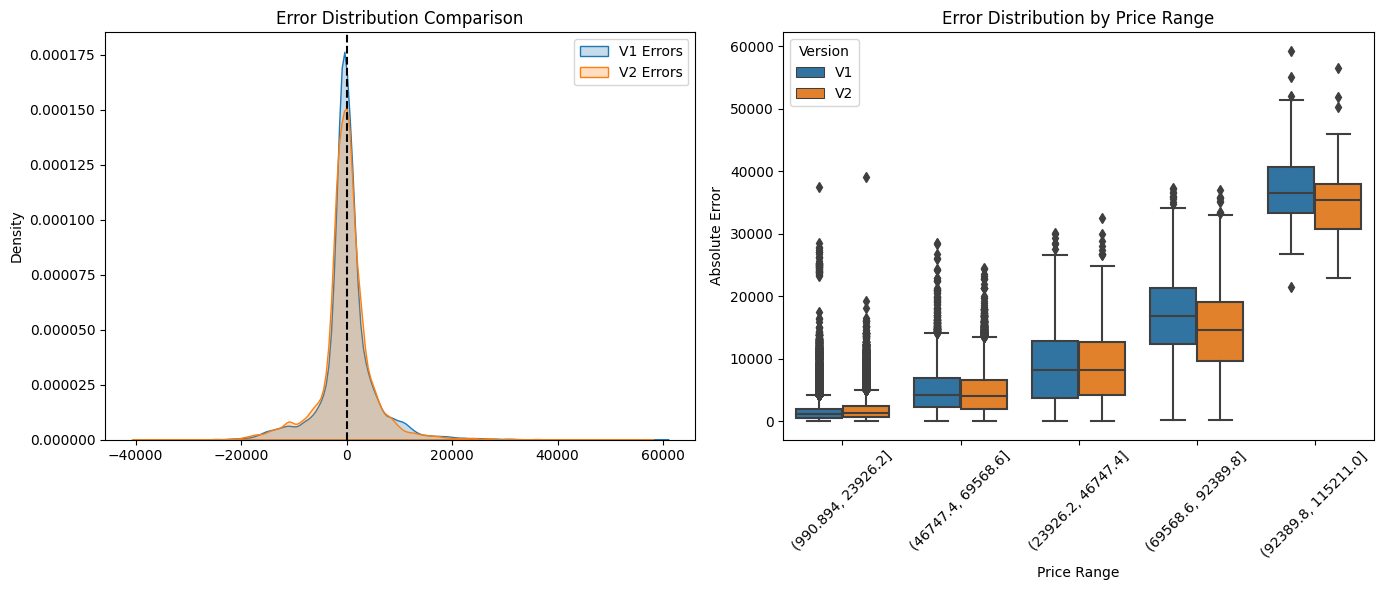


Top 10 Features by Importance:


In [22]:
print("MODEL VERSION COMPARISON")

# Metric comparison
metrics_comparison = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'R²', 'Explained Variance'],
    'V1': [mae_v1, rmse_v1, r2_v1, evs_v1],
    'V2': [mae_v2, rmse_v2, r2_v2, evs_v2]
})

# Calculate improvements
metrics_comparison['Improvement'] = metrics_comparison['V1'] - metrics_comparison['V2']
metrics_comparison['% Improvement'] = (
    metrics_comparison['Improvement'] / metrics_comparison['V1'] * 100
)

print("\nPerformance Comparison:")
print(metrics_comparison)

# Error distribution comparison
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.kdeplot(y_test_v1.values - y_pred_v1.flatten(), label='V1 Errors', fill=True)
sns.kdeplot(y_test_v2.values - y_pred_v2.flatten(), label='V2 Errors', fill=True)
plt.axvline(0, color='k', linestyle='--')
plt.title('Error Distribution Comparison')
plt.legend()

# MAE by price tier comparison
plt.subplot(1, 2, 2)
price_bins = pd.cut(pd.concat([y_test_v1, y_test_v2]), bins=5)
error_df = pd.DataFrame({
    'Price Range': list(price_bins),
    'Absolute Error': np.abs(np.concatenate([
        y_test_v1.values - y_pred_v1.flatten(),
        y_test_v2.values - y_pred_v2.flatten()
    ])),
    'Version': ['V1'] * len(y_test_v1) + ['V2'] * len(y_test_v2)
})
sns.boxplot(x='Price Range', y='Absolute Error', hue='Version', data=error_df)
plt.xticks(rotation=45)
plt.title('Error Distribution by Price Range')
plt.tight_layout()
plt.show()

# Feature importance analysis
print("\nTop 10 Features by Importance:")
# (Add your feature importance code here)

## 8. Deep Dive: Version 2 Residual Analysis

DETAILED ANALYSIS OF V2 MODEL


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


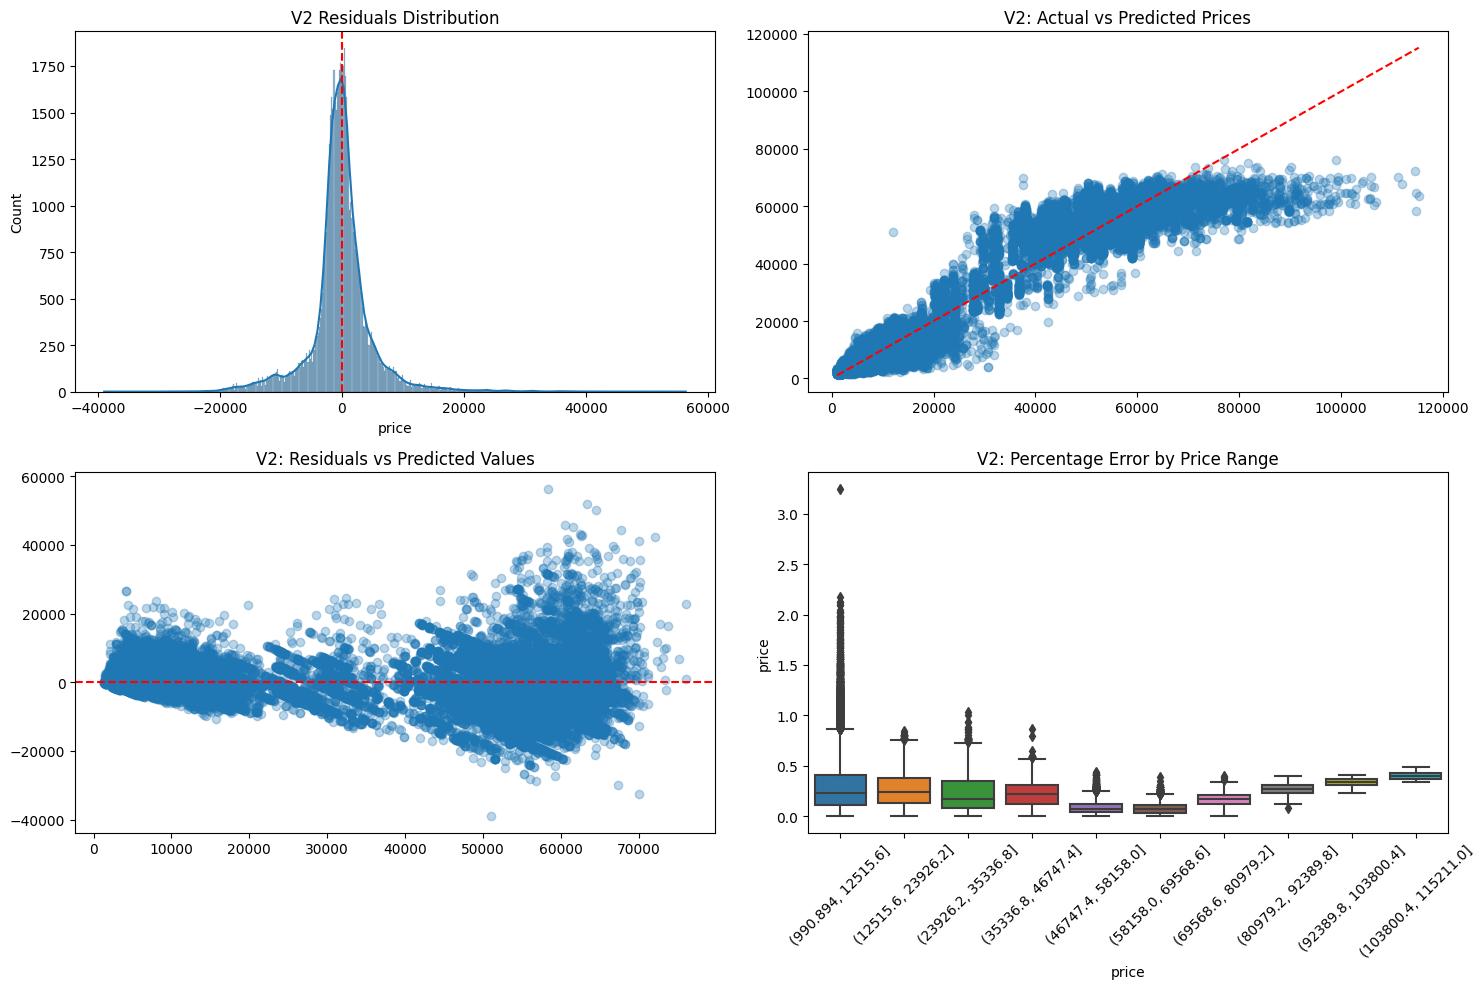


V2 Top 10 Worst Predictions:
        Actual     Predicted  Absolute Error
270999  114705  58296.554688    56408.445312
277345  115211  63404.332031    51806.667969
290568  114704  64501.890625    50202.109375
291083  106416  60530.656250    45885.343750
270367  106753  61560.761719    45192.238281
241599  111964  67671.867188    44292.132812
290566  105744  62466.359375    43277.640625
290691  105744  62743.105469    43000.894531
253990  105168  62616.984375    42551.015625
215858  114434  72124.882812    42309.117188


In [23]:
print("DETAILED ANALYSIS OF V2 MODEL")

# Residual analysis
residuals_v2 = y_test_v2 - y_pred_v2.flatten()

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(residuals_v2, kde=True)
plt.title('V2 Residuals Distribution')
plt.axvline(x=0, color='r', linestyle='--')

plt.subplot(2, 2, 2)
plt.scatter(y_test_v2, y_pred_v2, alpha=0.3)
plt.plot([y_test_v2.min(), y_test_v2.max()], 
         [y_test_v2.min(), y_test_v2.max()], 'r--')
plt.title('V2: Actual vs Predicted Prices')

plt.subplot(2, 2, 3)
plt.scatter(y_pred_v2, residuals_v2, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('V2: Residuals vs Predicted Values')

plt.subplot(2, 2, 4)
error_percent_v2 = np.abs(residuals_v2) / y_test_v2
sns.boxplot(x=pd.cut(y_test_v2, bins=10), y=error_percent_v2)
plt.xticks(rotation=45)
plt.title('V2: Percentage Error by Price Range')

plt.tight_layout()
plt.show()

# Top 10 error cases
worst_predictions_v2 = pd.DataFrame({
    'Actual': y_test_v2,
    'Predicted': y_pred_v2.flatten(),
    'Absolute Error': np.abs(residuals_v2)
}).sort_values('Absolute Error', ascending=False).head(10)

print("\nV2 Top 10 Worst Predictions:")
print(worst_predictions_v2)